In [241]:
import numpy as np
np.random.seed(1337)
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from collections import deque
import random
import urllib, json
import re
from datetime import datetime
import requests


In [334]:
memory = deque(maxlen=2000)
gamma = 0.95  
epsilon = 0.01  # exploration rate
epsilon_min = 0.01
epsilon_decay = 0.99
learning_rate = 0.001
batch_size = 32
memory = []
action_hist = []
class Account:
    cash = 100000
    amount_held = 0
    def calc_value(self,current_price):
        return self.amount_held * current_price
account = Account()

In [333]:
def build_network(input_sz):
    model = Sequential()
    model.add(Dense(125,input_dim=input_sz, activation='relu'))
    model.add(Dense(50,activation='relu'))
    model.add(Dense(2, activation='linear'))
    try:
        model.load_weights("rltrader.h5")
        print "LOADEd weights"
    except:
        pass
    model.compile(loss='mse',optimizer=Adam(lr=learning_rate)) 
    return model

In [244]:
def get_data(symbol):
    url = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&outputsize=full&symbol="+symbol+"&apikey=TOGGSCK5JLEEJTGL"
    url_rsi = "https://www.alphavantage.co/query?function=RSI&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    url_sma = "https://www.alphavantage.co/query?function=SMA&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    url_cci = "https://www.alphavantage.co/query?function=CCI&symbol="+symbol+"&interval=daily&time_period=10&series_type=close&apikey=TOGGSCK5JLEEJTGL"
    
    response_prices = requests.get(url)
    response_rsi = requests.get(url_rsi)
    response_sma = requests.get(url_sma)
    response_cci = requests.get(url_cci)
    
    data = response_prices.json()
    data_rsi = response_rsi.json()
    data_sma = response_sma.json()
    data_cci = response_cci.json()
    
    
    data = data["Time Series (Daily)"]
#     print(data_rsi)
    data_rsi = data_rsi["Technical Analysis: RSI"]
    data_sma = data_sma["Technical Analysis: SMA"]
    data_cci = data_cci["Technical Analysis: CCI"]
    
    ds = {}
    ds["date"] = []
    ds["close"] = []
    ds["open"] = []
    ds["volume"] = []
    ds["high"] = []
    ds["low"] = []
    ds["rsi"] = []
    ds["sma"] = []
    ds["cci"] = []
    
    i = 0
    for time_point in data:
        try:
            ds["date"] += [time_point]
            ds["close"] += [float(data[time_point]["4. close"])]
            ds["open"] += [float(data[time_point]["1. open"])]
            ds["volume"] += [float(data[time_point]["5. volume"])]
            ds["high"] += [float(data[time_point]["2. high"])]
            ds["low"] += [float(data[time_point][ "3. low"])]
        except KeyError as e:
            continue
        try:
            ds["rsi"] += [float(data_rsi[time_point]["RSI"])]
        except KeyError as e:
            ds["rsi"] += [sum(ds["rsi"])/len(ds["rsi"])]
        try:
            ds["sma"] += [float(data_sma[time_point]["SMA"])]
        except KeyError as e:
            ds["sma"] += [sum(ds["sma"])/len(ds["sma"])]
        try:
            ds["cci"] += [float(data_cci[time_point]["CCI"])]
        except KeyError as e:
            ds["cci"] += [sum(ds["cci"])/len(ds["cci"])]
    
    df=pd.DataFrame(ds)
    df = df.sort_values(by='date')
    df = df.reset_index(drop=True)
    return df
        


In [245]:
def remember(s,a,r,sp):
    memory.append((s,a,r,sp))

In [246]:
def update(memory):
#     Take random sample from memory
    batch = random.sample(memory, batch_size) 
#     Train network on batch
    for s, a, r, sp in batch:
#       if state is final there is no future rewards
        target = r
#       discounted future rewards
    
        target = r + gamma * \
           np.amax(model.predict(sp)[0])
                
#       Get pred then replace action with our target
        target_f = model.predict(s)
        target_f[0][a] = target
        model.fit(s, target_f, epochs=1, verbose=0)

In [325]:
def get_act(obs):
#     epsilon = epsilon*epsilon_decay
    if np.random.rand() <= epsilon:
        # The agent acts randomly
#         epsilon = epsilon*epsilon_decay
        act = int(random.uniform(0, 2))
        return act
  
    # Predict the reward value based on the given state
    act_values = model.predict(obs)

    # Pick the action based on the predicted reward
    return np.argmax(act_values[0])

In [324]:
int(random.uniform(0, 2))

1

In [326]:

def act(act,day):

    if act == 1:
        buy["buy"] += [day[1]["close"]]
        buy["date"] += [df_d.date.iloc[day[0]]]
        if (account.cash - day[1]["close"]) >= 0:
            account.amount_held =  account.amount_held + 1
            account.cash = account.cash - day[1]["close"]
            current_val = account.calc_value(day[1]["close"])
            i = day[0]
            future = df.iloc[i+7]
            if (account.calc_value(future.close) - current_val) > 0:
                return 1
            else:
                return -1
    #         Buy some shares reward is if we make money in a week
    else:
        sell["sell"] += [day[1]["close"]]
        sell["date"] += [df_d.date.iloc[day[0]]]
        if account.amount_held > 0:
            account.amount_held = account.amount_held -1
            account.cash = account.cash + (1*day[1]["close"])
        current_val = account.calc_value(day[1]["close"])
        i = day[0]

        future = df.iloc[i+7]

        if (account.calc_value(future.close) - current_val) < 0:
            return 1
        else:
            return -1
    
    return 0
#         Sell some shares reward is if we avoid losing money in a week

In [249]:

#     print d[1]["date"]


In [341]:
range(0,1)

[0]

In [342]:
model = build_network(len(df.columns))
prv_obs = None

buy = {}
buy["buy"] = []
buy["date"] = []
sell = {}
sell["sell"] = []
sell["date"] = []

gl = []
epochs = 1
df_d = None
codes = ["ASX:RBL","TSLA","MSFT","MU","ASX:ANZ"]
for epoch in range(0,epochs):
    buy = {}
    buy["buy"] = []
    buy["date"] = []
    sell = {}
    sell["sell"] = []
    sell["date"] = []
    i = 0
    memory = deque(maxlen=2000)
    account = Account()
    df = get_data(random.choice(codes))
    df_d = df[["date","close"]]

    del df["date"]
    for day in df.iterrows():
        i = 1 + i
    #     print i
        if i == len(df) - 11:
            model.save_weights("rltrader.h5")
            print("Episode finished after {} timesteps".format(i+1))
            break
        obs = day[1]
        obs_values = np.reshape(obs.values,[1,len(df.columns)])
        action = get_act(obs_values )
        if action == 1:
            action_hist += ["buy"] 
        else:
            action_hist += ["sell"]
        if i % 100 == 0:
            if action == 1:
                print "Buying" 
            else:
                print "Selling"
            print "day" , i
            print "cash",account.cash
            print "shares held",account.amount_held
            print "net worth",account.calc_value(day[1]["close"]) + account.cash

    #     print(action)
        reward = act(action,day)
    #     print reward
        gl += [(account.calc_value(day[1]["close"]) + account.cash) - 100000]
        if prv_obs is not None and reward is not None:
            remember(prv_obs,action,reward,obs_values)
        prv_obs = obs_values  
    #     if done:
    #         model.save_weights("model.h5")
    #         print("Episode finished after {} timesteps".format(t+1))
    #         break
        if len(memory) >= batch_size:
            update(memory)

LOADEd weights
Selling
day 100
cash 98075.4
shares held 9
net worth 98665.44
Selling
day 200
cash 98503.33
shares held 2
net worth 98604.09
Buying
day 300
cash 94638.82
shares held 70
net worth 98274.62
Buying
day 400
cash 88055.64
shares held 170
net worth 99522.14
Buying
day 500
cash 82003.25
shares held 268
net worth 99758.25
Buying
day 600
cash 76176.13
shares held 366
net worth 95669.29
Buying
day 700
cash 71320.74
shares held 464
net worth 94710.98
Buying
day 800
cash 66904.48
shares held 556
net worth 79909.32
Buying
day 900
cash 64345.45
shares held 656
net worth 81519.53
Buying
day 1000
cash 61634.03
shares held 756
net worth 82076.27
Buying
day 1100
cash 58988.524
shares held 856
net worth 80919.244
Buying
day 1200
cash 56238.07
shares held 956
net worth 83034.75
Buying
day 1300
cash 53543.641
shares held 1056
net worth 80439.961
Buying
day 1400
cash 51029.601
shares held 1156
net worth 80796.601
Buying
day 1500
cash 48381.4213
shares held 1256
net worth 82079.9013
Buying
day

In [343]:
print ((sum(gl)/len(gl))/100000)*100

# print (164921.0158/100000)*100
# print action_hist

-0.000498279315165


In [344]:
df_buys = pd.DataFrame(buy)
df_sells = pd.DataFrame(sell)

In [ ]:
df_d

In [ ]:
df_sells

In [ ]:
# df_d.plot()
df_sells

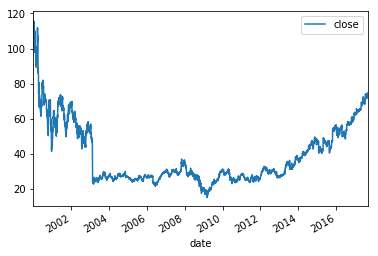

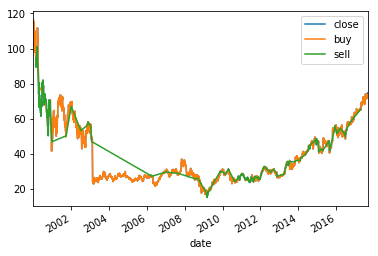

In [345]:
df_d.date = pd.to_datetime(df_d.date,format='%Y-%m-%d')
df_d = df_d.set_index("date")
df_buys.date = pd.to_datetime(df_buys.date,format='%Y-%m-%d')
df_buys = df_buys.set_index("date")
df_sells.date = pd.to_datetime(df_sells.date,format='%Y-%m-%d')
df_sells = df_sells.set_index("date")
ax = df_d.plot()

ax = df_d.plot()
ax = df_buys.plot(ax=ax)
df_sells.plot(ax=ax)
# # df_sells.groupby(df_sells["date"])
plt.show()

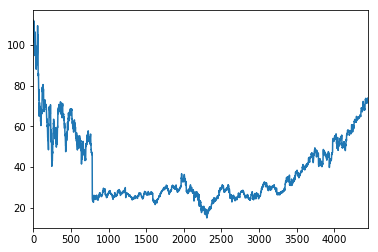

In [355]:
df.low.plot()

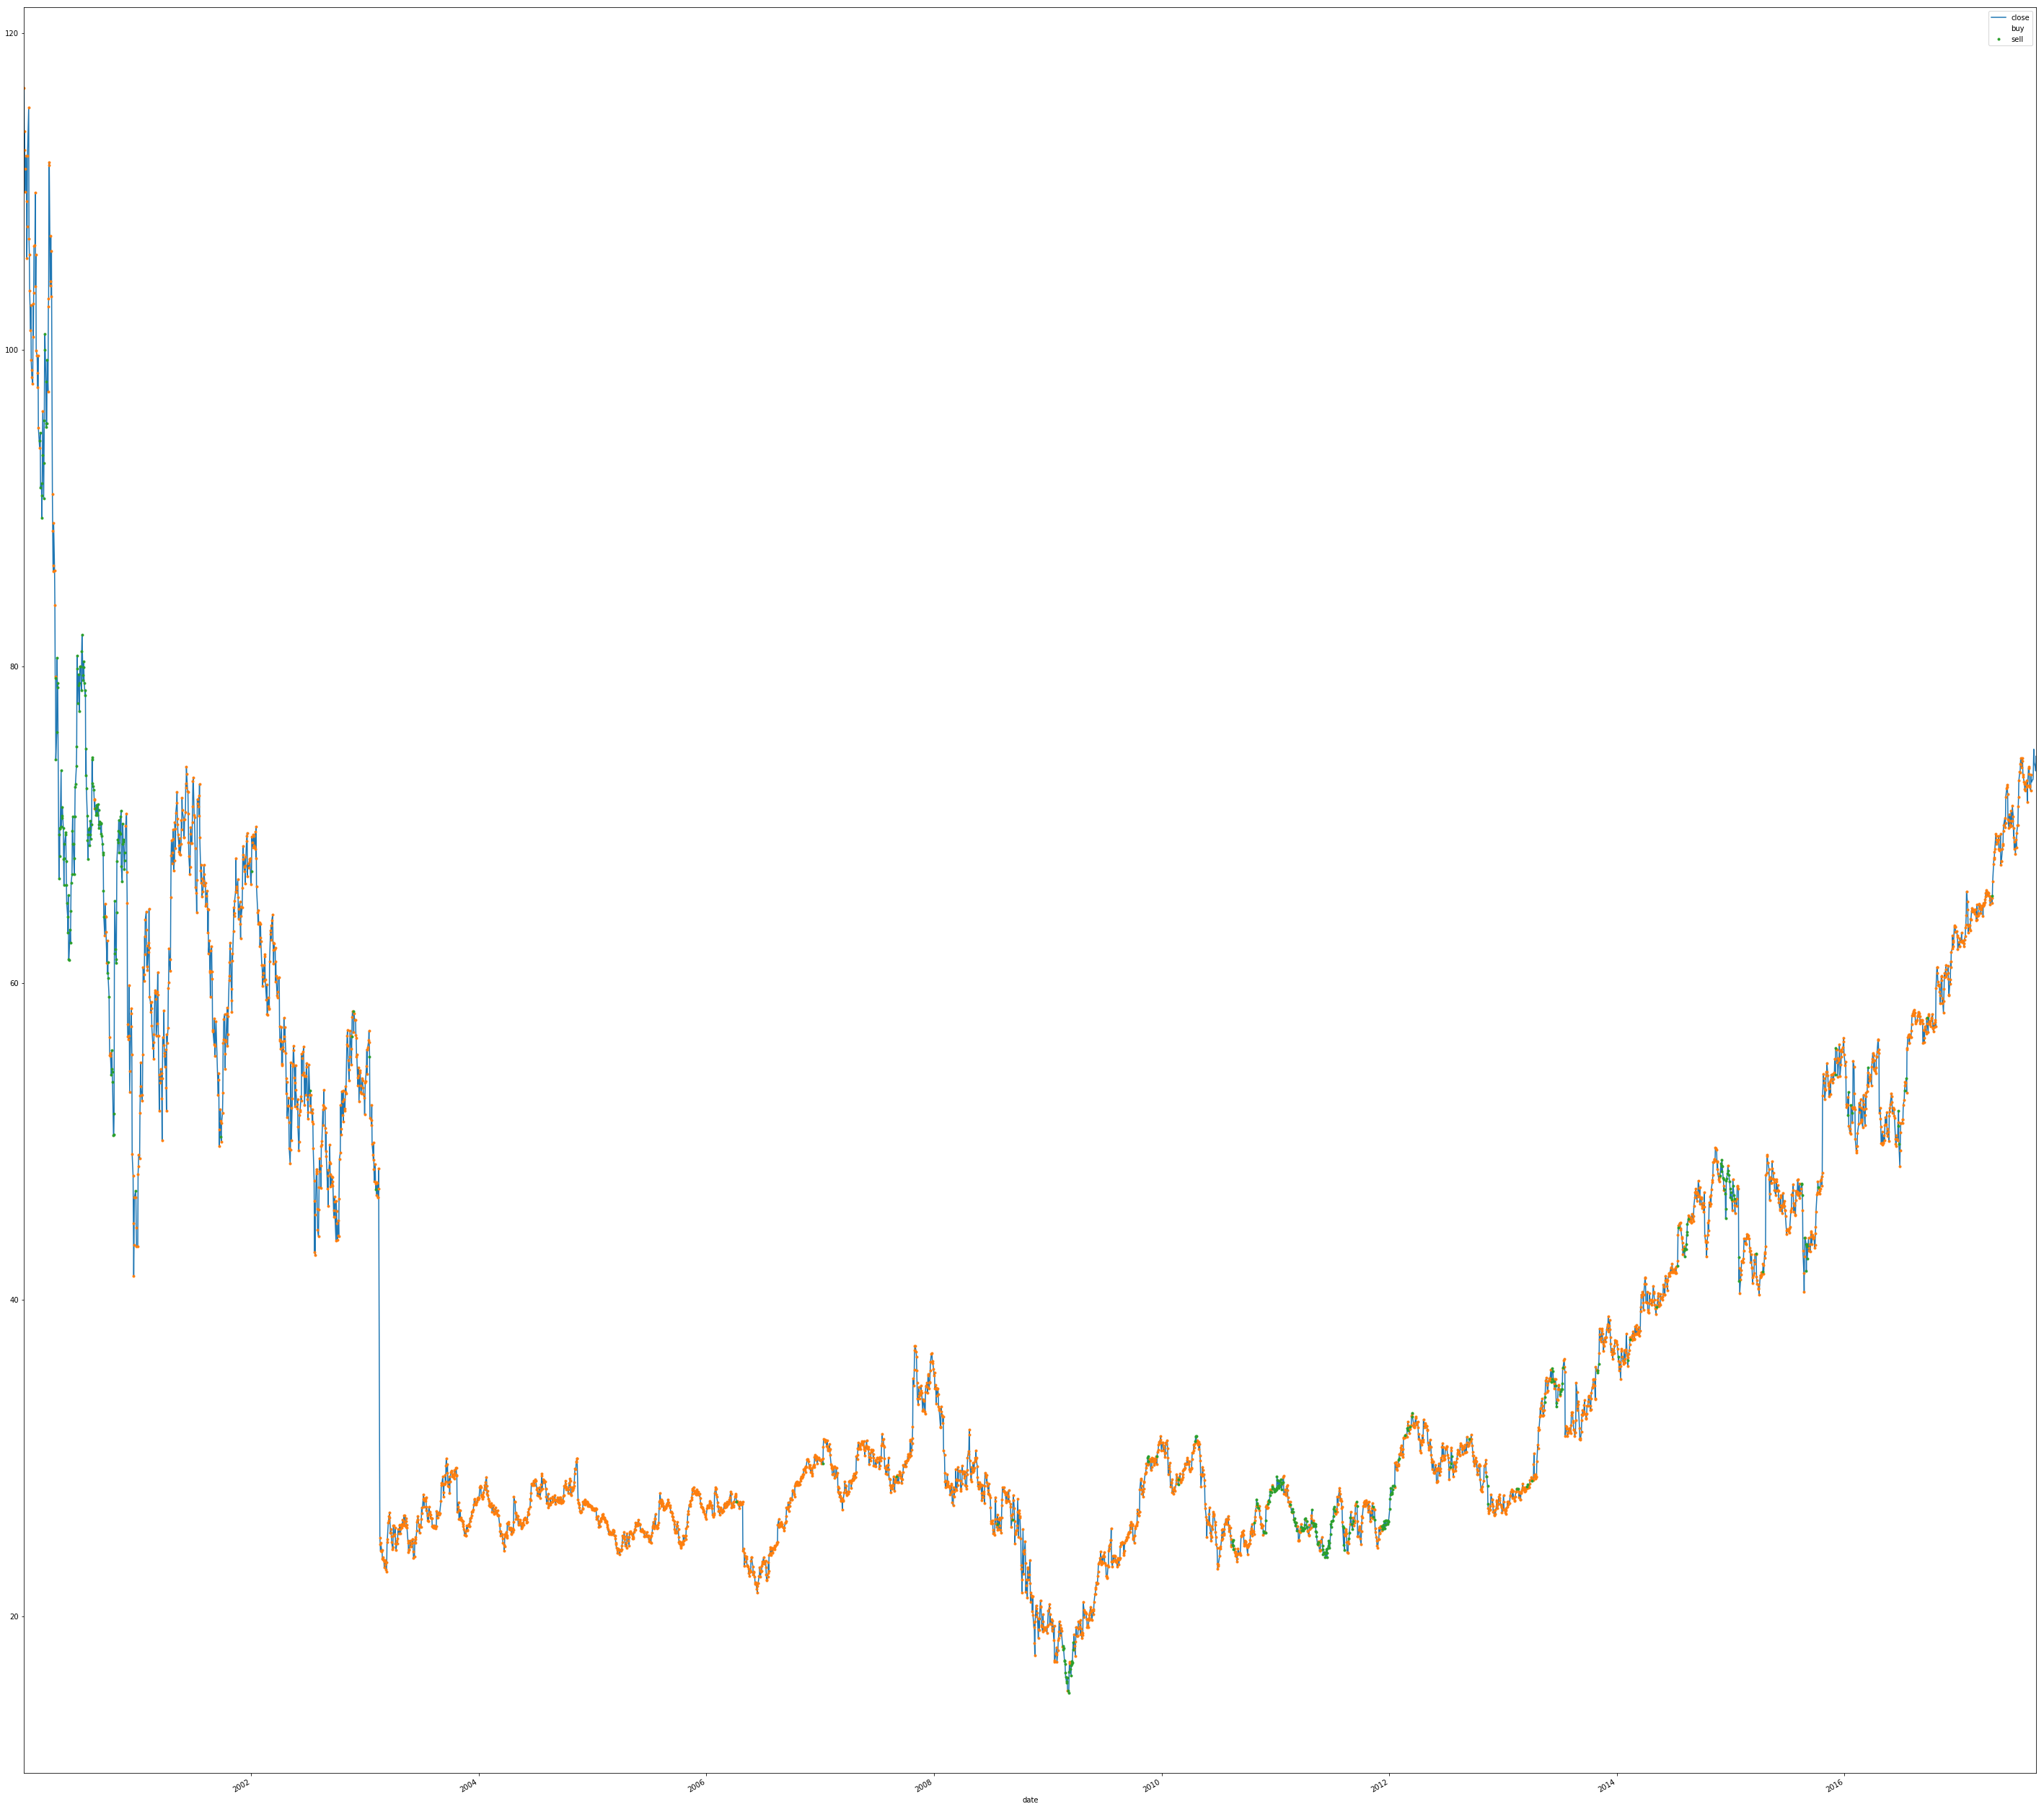

In [358]:
fig = plt.figure(figsize = (50,50))
ax = fig.gca()

ax = df_d.plot(ax=ax)
ax = df_buys.plot(style=".",ax=ax)
df_sells.plot(style=".",ax=ax)
# # df_sells.groupby(df_sells["date"])
plt.show()

In [ ]:
df_d

In [ ]:
%%bash
which python